# Social Media Trend Analysis

In [2]:
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

## Load Dataset

### revenue dataset

In [3]:
nio_revenue = "data/nio_revenue.csv"
nio_stock_price = "data/nio_stock_price.csv"
nio_tweets ="data/nio_tweets.csv"
df_revenue = pd.read_csv(nio_revenue)
df_stock_price = pd.read_csv(nio_stock_price)
df_tweets = pd.read_csv(nio_tweets)

In [4]:
df_revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   period            8 non-null      object
 1   fiscalDateEnding  8 non-null      object
 2   reportedCurrency  8 non-null      object
 3   totalRevenue      8 non-null      int64 
dtypes: int64(1), object(3)
memory usage: 384.0+ bytes


In [5]:
df_revenue.describe()

,totalRevenue
count,8.000000e+00
mean,3.010356e+09
std,1.860366e+09
min,1.371952e+09
25%,1.600513e+09
50%,2.342586e+09
75%,3.920688e+09
max,6.641100e+09


In [6]:
df_revenue.head()

,period,fiscalDateEnding,reportedCurrency,totalRevenue
0,quarter,3/31/19 0:00,CNY,1631161000
1,quarter,6/30/19 0:00,CNY,1508570000
2,quarter,9/30/19 0:00,CNY,1836844000
3,quarter,12/31/19 0:00,CNY,2848329000
4,quarter,3/31/20 0:00,CNY,1371952000


### stock price dataset

In [7]:
df_stock_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558 entries, 0 to 557
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    558 non-null    object 
 1   Close   558 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.8+ KB


In [8]:
df_stock_price.describe()

,Close
count,558.000000
mean,13.943978
std,17.402313
min,1.320000
25%,3.112500
50%,4.890000
75%,17.847500
max,62.840000


In [9]:
df_stock_price.head()

,Date,Close
0,3/19/21,43.35
1,3/18/21,41.63
2,3/17/21,44.76
3,3/16/21,43.68
4,3/15/21,44.93


### tweets dataset

In [10]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34288 entries, 0 to 34287
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   created_at        34288 non-null  object
 1   user_screen_name  34288 non-null  object
 2   text              34288 non-null  object
 3   like_count        34288 non-null  int64 
 4   share_count       34288 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.3+ MB


In [11]:
df_tweets.describe()

,like_count,share_count
count,34288.000000,34288.000000
mean,9.626808,1.366105
std,68.243090,11.218692
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,3.000000,0.000000
max,2677.000000,499.000000


In [12]:
df_tweets.head()

,created_at,user_screen_name,text,like_count,share_count
0,3/19/21 23:53,GabrielUtasi,@Fatalflow5 @NIOGlobal for sure. I lost 1/2 my...,0,0
1,3/19/21 23:27,TheIronGiant8,"""Why Nio Stock Is a Buy Right Now""~@moneymorni...",22,4
2,3/19/21 22:47,TheIronGiant8,"@dum_online @nio I think you mean @NIOGlobal, ...",0,0
3,3/19/21 22:12,Badir32981778,@NIOGlobal $nio\n3.4 Million shares were trade...,0,0
4,3/19/21 20:47,ImBananas4,@NIOGlobal @markets Any chance you guys develo...,0,0


## Data Processing and Cleaning

In [4]:
# Change time format
df_stock_price['Date_Formatted'] = pd.to_datetime(df_stock_price['Date'].astype('str'), format = "%m/%d/%y")
df_tweets['created_at_Formatted'] = pd.to_datetime(df_tweets['created_at'].astype('str'), format = "%m/%d/%y %H:%M")

## Question 1

### a

In [13]:
def plot_popularity(df_tweets, metric):
    
    """
    This is a function to plot popularity that measured by number of tweets, share_count and like_count
    metric can be 'tweets', 'share_count', 'like_count'

    """
    if metric == 'tweets':
        df_tweets['tweet_indicator'] = np.ones(len(df_tweets))
        metric = 'tweet_indicator'
        
    df_tweets[f'rate_1D_{metric}'] = (df_tweets.rolling('1D',on = 'created_at_Formatted').sum()[f'{metric}']-1)*1
    df_tweets[f'rate_7D_{metric}'] = (df_tweets.rolling('7D',on = 'created_at_Formatted').sum()[f'{metric}']-1)*1/7
    df_tweets[f'rate_30D_{metric}'] = (df_tweets.rolling('30D',on = 'created_at_Formatted').sum()[f'{metric}']-1)*1/30
    df_tweets[f'rate_90D_{metric}'] = (df_tweets.rolling('90D',on = 'created_at_Formatted').sum()[f'{metric}']-1)*1/90
    fig = plt.figure(figsize = (12,6))
    sns.lineplot(data = df_tweets, x = "created_at_Formatted", y = f'rate_1D_{metric}',linewidth = 0.25, color = 'blue',label = 'window = 1 day')
    sns.lineplot(data = df_tweets, x = "created_at_Formatted", y = f'rate_7D_{metric}',linewidth = 1, color = 'red',label = 'window = 7 day')
    sns.lineplot(data = df_tweets, x = "created_at_Formatted", y = f'rate_30D_{metric}',linewidth = 1.25, color = 'green',label = 'window = 30 day')
    sns.lineplot(data = df_tweets, x = "created_at_Formatted", y = f'rate_90D_{metric}',linewidth = 1.5, color = 'black',label = 'window = 90 day')
    plt.grid()
    plt.ylabel("Rate [tweets/day]",fontsize = 16)
    plt.xlabel("Date",fontsize = 16)
    if metric == 'tweet_indicator':
        plt.title(f"popularity trend, using metric: number of tweets",fontsize = 20)
    elif metric == 'share_count':
        plt.title(f"popularity trend, using metric: number of share count",fontsize = 20)
    elif metric == 'like_count':
        plt.title(f"popularity trend, using metric: number of like count",fontsize = 20) 
    

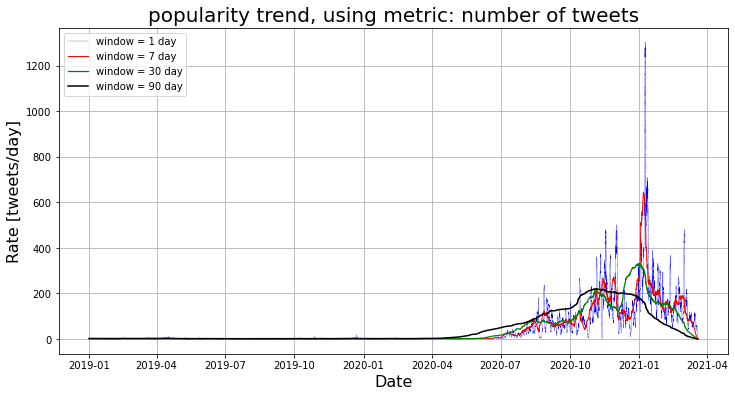

In [113]:
# Visualize popularity trend measured by number of posts/tweets
plot_popularity(df_tweets, 'tweets')

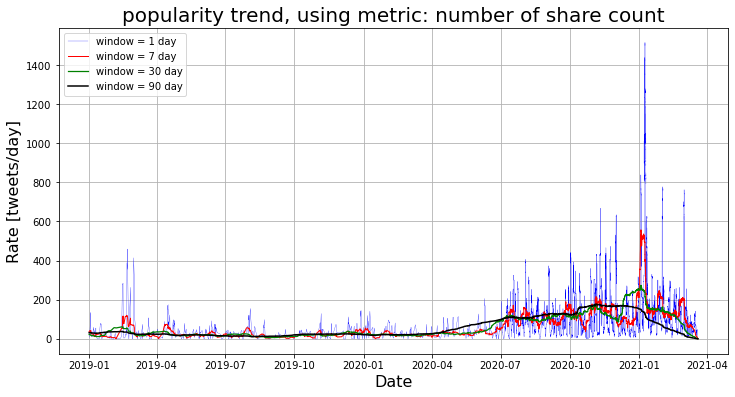

In [112]:
# Visualize popularity trend measured by number of share_count
plot_popularity(df_tweets, 'share_count')

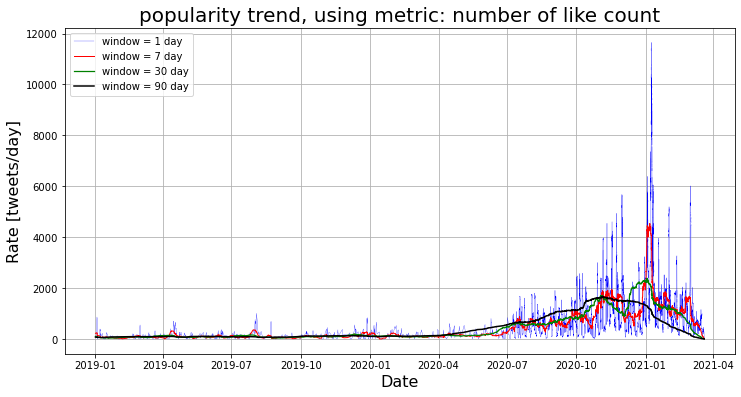

In [114]:
# Visualize popularity trend measured by number of like_count
plot_popularity(df_tweets, 'like_count')

Using metrics: the number of posts/tweets, share_count, and like_count, the popularity kept low during Jan 2019 to Apr 2020 and then increased from Apr 2020 to Jan 2021. In Jan 2021, the popularity increased dramatically and then returned to normal. From Jan 2021 to Apr 2021, the popularity decreased a little.  

### b 

#### Sentiment Classification with BERT

In [5]:
# Sentiment Classification with BERT
# Download Pre-Traine Model and Tokenizer
# The output sentiment is between 1 and 5.(1 means a bad review, and a value fo 5 means an excellent review)
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

In [15]:
def sentiment_classifier(text,model,tokenizer):
    
    """
    This function takes as input a string text, a transformer model called model, and a tokenizer called tokenizer, 
    and returns the sentiment and embedding of the text. 
    """
    
    inputs = tokenizer.encode_plus(text, return_tensors='pt', add_special_tokens=True)

    token_type_ids = inputs['token_type_ids']
    input_ids = inputs['input_ids']

    output = model(input_ids, token_type_ids=token_type_ids,return_dict=True,output_hidden_states=True)
    logits = np.array(output.logits.tolist()[0])
    prob = np.exp(logits)/np.sum(np.exp(logits))
    sentiment = np.sum([(x+1)*prob[x] for x in range(len(prob))])  # use the mean score
    #sentiment = logits.argmax()  
    embedding = output.hidden_states[12].detach().numpy().squeeze()[0]
    return sentiment,embedding


In [21]:
# Calculate Sentiment and Transformer Embedding of Tweets
Sentiment = []
Embedding = []
for index,row in df_tweets.iterrows():
    sentiment,embedding = sentiment_classifier(row.text,model,tokenizer)
    Sentiment.append(sentiment)
    Embedding.append(embedding)
df_tweets['sentiment'] = Sentiment
df_tweets.to_csv("data/tweets_sentiment_embedding.csv")
df_tweets.head()

In [39]:
# load the saved data
df_tweets_with_sentiment = pd.read_csv("data/tweets_sentiment_embedding.csv")
df_tweets_with_sentiment['created_at_Formatted'] = pd.to_datetime(df_tweets['created_at'].astype('str'), format = "%m/%d/%y %H:%M")

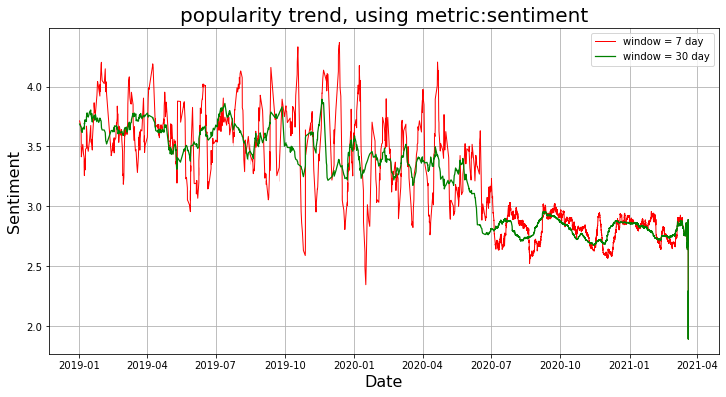

In [54]:
# Only keeps window of 7 days and 30 days, since these two are stable, but not too stable
metric = 'sentiment'
df_tweets_with_sentiment[f'rate_7D_{metric}'] = (df_tweets_with_sentiment.rolling('7D',on = 'created_at_Formatted').mean()[f'{metric}'])
df_tweets_with_sentiment[f'rate_30D_{metric}'] = (df_tweets_with_sentiment.rolling('30D',on = 'created_at_Formatted').mean()[f'{metric}'])
fig = plt.figure(figsize = (12,6))
sns.lineplot(data = df_tweets_with_sentiment, x = "created_at_Formatted", y = f'rate_7D_{metric}',linewidth = 1, color = 'red',label = 'window = 7 day')
sns.lineplot(data = df_tweets_with_sentiment, x = "created_at_Formatted", y = f'rate_30D_{metric}',linewidth = 1.25, color = 'green',label = 'window = 30 day')
plt.grid()
plt.ylabel("Sentiment",fontsize = 16)
plt.xlabel("Date",fontsize = 16)
plt.title(f"popularity trend, using metric:sentiment",fontsize = 20)    
plt.savefig(f'{metric}.png')

In the beginning, Jan 2019, the sentiment of tweets was positive(3.6/5) and kept decreasing toJun 2020(3.1). In Jun 2020, the sentiment decreased significantly to about 2.8. From Jul 2020 to Mar 2021, the sentiment kept steady at around 2.8.

## Question 2

We will see the topics of tweets and show the word cloud of it to understand why these peaks existed. 

### Using lda to find topics

In [44]:
# select these two peaks
df_tweets_Jan = df_tweets[(df_tweets['created_at_Formatted']>datetime.datetime(2020, 12, 15)) & 
                         (df_tweets['created_at_Formatted']<datetime.datetime(2021, 1, 15))]
df_tweets_Nov = df_tweets[(df_tweets['created_at_Formatted']>datetime.datetime(2020, 10, 15)) & 
                         (df_tweets['created_at_Formatted']<datetime.datetime(2020, 11, 15))]

# initialize the CountVectorizer and tell it to remove English stopwords with the stop_words
num_topics = 3
tf_vectorizer_Jan = CountVectorizer(min_df=5, stop_words='english')
tf_embedding_Jan = tf_vectorizer_Jan.fit_transform(df_tweets_Jan.text)
tf_feature_names_Jan = tf_vectorizer_Jan.get_feature_names()
lda_Jan = LatentDirichletAllocation(n_components=num_topics, max_iter=5, 
                                learning_method='online', learning_offset=50.,
                                random_state=0).fit(tf_embedding_Jan)

tf_vectorizer_Nov = CountVectorizer(min_df=5, stop_words='english')
tf_embedding_Nov = tf_vectorizer_Nov.fit_transform(df_tweets_Nov.text)
tf_feature_names_Nov = tf_vectorizer_Nov.get_feature_names()
lda_Nov = LatentDirichletAllocation(n_components=num_topics, max_iter=5, 
                                learning_method='online', learning_offset=50.,
                                random_state=0).fit(tf_embedding_Nov)

In [45]:
def display_topics(model, feature_names, num_top_words):
    """
    show the top num_top_words words in each topic
    """
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx+1}")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))

num_top_words = 10
print("LDA topics\n")
print("Jan 2021\n")
display_topics(lda_Jan, tf_feature_names_Jan, num_top_words)
print("\n")
print("Nov 2020\n")
display_topics(lda_Nov, tf_feature_names_Nov, num_top_words)

LDA topics

Jan 2021

Topic 1
nioglobal, nio, https, dcdowork, niogang, hogarthhughes8, blueskycoming, nionenad, nionation, tsla
Topic 2
nioglobal, ford, matthewcarlyle7, darbysx5, richardbranson, tedtates, like, quicktake, tommackenzietv, just
Topic 3
nioglobal, nio, tesla, https, day, year, battery, new, ev, just


Nov 2020

Topic 1
nioglobal, dcdowork, nio, day, stock, like, share, cnbc, company, 1000
Topic 2
nioglobal, yahoofinance, china, tesla, ezintenso, business, car, driveteslaca, cars, market
Topic 3
nioglobal, nio, tesla, https, chesterinvest, tsla, tslaq, nioq, ragingbull_92, dcdowork


From the top topic in Jan 2021, these tweets seemed like retweeting 'nioglobal', 'dcdowork(Entrepreneur, Investor)' 'nionenad(NIO investor)'. And the topics are like 'nionation(stock)', and 'niogang'. These show that the main topic of all the tweets in Jan 2021 is stock and investment. 
The topic of Nov 2020 is similar. these words 'dcdowork',  'stock', 'share' are about the stocks.   

Plot the word clouds for these two peaks. 

### Plot wordcloud

In [46]:
def plot_wordcloud(df,stopwords):
    """
    This is a function to plot he wordcloud for all the tweets
    df is the dataframe, and stopwords are the words we do not want to be included in the analysis
    """
    text=' '.join(df.text.tolist()).lower()
    wordcloud = WordCloud(stopwords=stopwords,max_font_size=150, max_words=100, background_color="white",width=1000, height=600)
    wordcloud.generate(text)
    plt.figure(figsize = (16,4))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    return 1

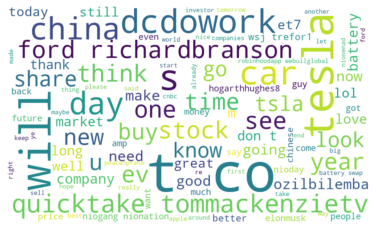

1

In [49]:
stopwords = set(STOPWORDS)
stopwords.add("nio")
stopwords.add("nioglobal")
stopwords.add('https')
plot_wordcloud(df_tweets_Jan,stopwords)

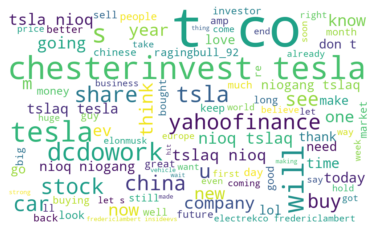

1

In [50]:
plot_wordcloud(df_tweets_Nov,stopwords)

### Visualize revenue and stock data
Visualize the revenue and stock data to see why people were talking about the stock. 

In [75]:
# Show revenue
df_revenue

,period,fiscalDateEnding,reportedCurrency,totalRevenue
0,quarter,3/31/19 0:00,CNY,1631161000
1,quarter,6/30/19 0:00,CNY,1508570000
2,quarter,9/30/19 0:00,CNY,1836844000
3,quarter,12/31/19 0:00,CNY,2848329000
4,quarter,3/31/20 0:00,CNY,1371952000
5,quarter,6/30/20 0:00,CNY,3718930000
6,quarter,9/30/20 0:00,CNY,4525960000
7,quarter,12/31/20 0:00,CNY,6641100000


Text(0.5, 1.0, 'Stock trend')

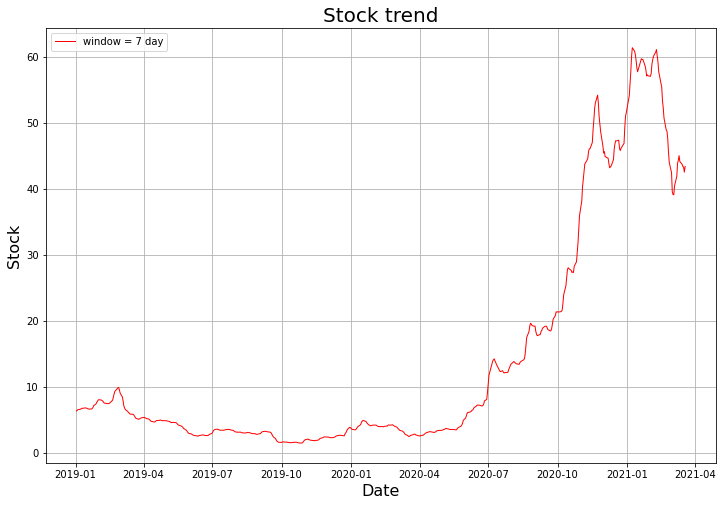

In [77]:
# show stock trend
fig = plt.figure(figsize = (12,8))

sns.lineplot(data = df_stock_price, x = "Date_Formatted", y = 'rate_7D_Close',linewidth = 1, color = 'red',label = 'window = 7 day')
plt.grid()
plt.ylabel("Stock",fontsize = 16)
plt.xlabel("Date",fontsize = 16)
plt.title(f"Stock trend",fontsize = 20) 

From the popularity trend we plotted, there are two peaks. One is about in Oct 2020 to Nov 2020, and the other is in Jan 2021. From the stock trend, the stock prices increased significantly from Oct 2020 to Nov 2020, so this peak in this month may because the stock is increasing and many people talked about it. The revenue in 2020Q4 is the highest of the last three years, and the stock peak achieved a peak in Jan 2021, so the peak in this month may because of the high stock and revenue. 

## Question 3

In [57]:
# Using return of the series not price
df_tweets['tweet_indicator'] = np.ones(len(df_tweets))
df_tweets['rate_7D_tweet'] = (df_tweets.rolling('7D',on = 'created_at_Formatted').sum()['tweet_indicator']-1)*1/7
df_stock_price['rate_7D_Close'] = (df_stock_price.rolling('7D',on = 'Date_Formatted').mean()['Close'])
df_tweets['rate_7D_tweet_Ret'] = df_tweets['rate_7D_tweet'].pct_change()
df_stock_price['rate_7D_Close_Ret'] = df_stock_price['rate_7D_Close'].pct_change()

Text(0.5, 1.0, 'Stock trend')

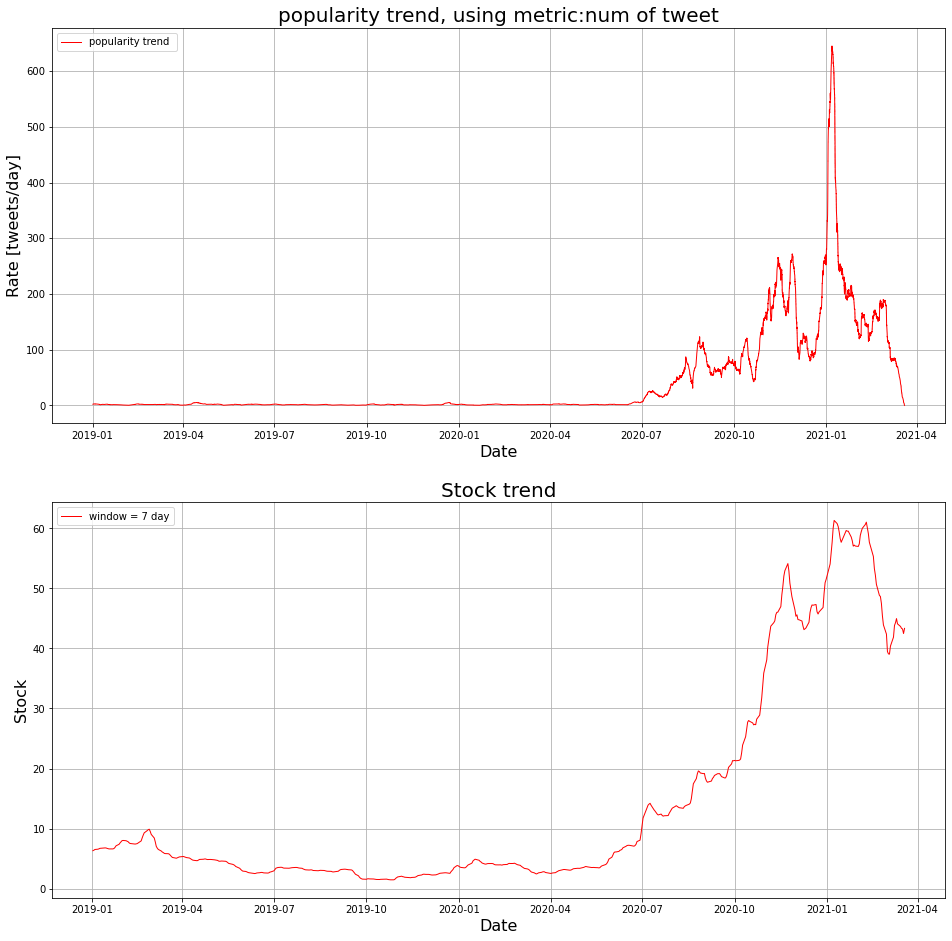

In [70]:
# Show popularity trend using 7 day window, measured by
fig = plt.figure(figsize = (16,16))
ax1 = plt.subplot(2,1,1)
sns.lineplot(data = df_tweets, x = "created_at_Formatted", y = 'rate_7D_tweet',linewidth = 1, color = 'red',label = 'popularity trend ')
plt.grid()
plt.ylabel("Rate [tweets/day]",fontsize = 16)
plt.xlabel("Date",fontsize = 16)
plt.title(f"popularity trend, using metric:num of tweet",fontsize = 20) 

ax2 = plt.subplot(2,1,2)
sns.lineplot(data = df_stock_price, x = "Date_Formatted", y = 'rate_7D_Close',linewidth = 1, color = 'red',label = 'window = 7 day')
plt.grid()
plt.ylabel("Stock",fontsize = 16)
plt.xlabel("Date",fontsize = 16)
plt.title(f"Stock trend",fontsize = 20)   

From the plots of stock and popularity, we believe there is a correlation between the social media trend and financial data. Since the trends of stock and popularity are similar to each other. 

In [104]:
# Calculate correlation
tweet_trend = df_tweets.resample('D', on='created_at_Formatted').sum()['tweet_indicator']
stock_trend = df_stock_price.resample('D', on='Date_Formatted').mean()['Close'].dropna()
correlation = tweet_trend.corr(stock_trend)
print(f'Correlation between social media trend and stock is: {correlation}')

Correlation between social media trend and stock is: 0.8358747858067446


And the correlation is over 0.83, which means a strong positive correlation. 